In [2]:
 %run "Link to the setup.ipynb script"
 from scipy.stats import ttest_ind

importing standardlib modules
importing google drive
importing tensorflow/keras modules
importing miscelaneaous modules


# Function definitions

In [3]:
# @title Run whole pipeline

def get_predictions(emotion_classifier: Model, cause_classifier: Model,
                    conversations: np.ndarray, emotions: np.ndarray,
                    causes: np.ndarray, indicies: np.ndarray,
                    use_emotion_prediction: bool = True,
                    force_padding_neutral: bool = True,
                    ) -> Tuple[np.ndarray, np.ndarray] :
  """Returns emotion and cause predictions for a batch of input data"""

  emotions_predicted = list()
  # predict emotions utterance by utterance
  for conv, emo, cause, ind in zip(conversations, emotions, causes, indicies):
    # determine conversation length
    conv_len = sum([np.any(utt) for utt in conv])
    emotions_conv = emotion_classifier.predict_on_batch(conv[:conv_len])
    if force_padding_neutral:
      # pad with neutral
      padding = np.repeat(np.array([[0., 0., 1., 0., 0., 0., 0.]]),
                          data_params["len_conversation"] - conv_len,
                          axis=0)
    else:
      # pad with model predictions
      padding = emotion_classifier.predict_on_batch(conv[conv_len:])
    emotions_conv = np.append(emotions_conv, padding, 0)
    emotions_predicted.append(emotions_conv)
  emotions_predicted = np.array(emotions_predicted)
  # predict causes for entire batch
  causes_predicted = cause_classifier.predict_on_batch(
      (utterances, emotions_predicted if use_emotion_prediction else emotions))
  return emotions_predicted, causes_predicted

In [4]:
# @title Evaluate whole pipeline

def evaluate_predictions(conversations: np.ndarray, emotions: np.ndarray,
                         causes: np.ndarray, indicies: np.ndarray,
                         emotions_predicted: np.ndarray,
                         causes_predicted: np.ndarray,
                         threshold_accept_pair: float = 0.5
                         ) -> Tuple[pd.DataFrame, pd.DataFrame]:
  """Returns two DataFrames, containg the evaulation results of emotion
     prediction, and emotion cause predicting"""

  # Evaluate emotion predictions
  emo_eval = {"conversation_ID": [], "utterance_ID": [], "target_emotion": [],
              "predicted_emotion": [], "correct": []}
  for conv, emo_target, emo_predicted, conv_ind in zip(
      conversations, emotions, emotions_predicted, indicies):
    conv_len = sum([np.any(utt) for utt in conv])
    emo_eval["conversation_ID"] += [conv_ind] * conv_len
    emo_eval["utterance_ID"] += list(range(1, conv_len+1))
    target_emotion_label = [data_params['emotions'][np.argmax(emo)]
                            for emo in emo_target[:conv_len]]
    predicted_emotion_label = [data_params['emotions'][np.argmax(emo)]
                               for emo in emo_predicted[:conv_len]]
    emo_eval["target_emotion"] += target_emotion_label
    emo_eval["predicted_emotion"] += predicted_emotion_label
    emo_eval["correct"] += [l1 == l2 for l1, l2 in zip(target_emotion_label,
                                                       predicted_emotion_label)]
  emo_eval = pd.DataFrame(emo_eval)

  # Evaluate cause predictions
  cause_eval = {"conversation_ID": [], "target_emotion": [],
                "predicted_emotion": [], "emotion_correct": [],
                "cause_utterance": [], "emotion_utterance": [],
                "correct": [], "predicted": []}
  causes = np.reshape(causes, [-1] + [data_params['len_conversation']]*2)
  causes_predicted = np.reshape(causes_predicted, [-1] +
   [data_params['len_conversation']]*2)

  for conv, emo_pred, emo_target, cause_target, cause_pred, conv_ind in zip(
      conversations, emotions_predicted, emotions, causes, causes_predicted, indicies):

    predicted_emotion_label = [data_params['emotions'][np.argmax(emo)]
                               for emo in emo_pred]
    target_emotion_label = [data_params['emotions'][np.argmax(emo)]
                            for emo in emo_target]

    for index, val in np.ndenumerate(cause_target):
      if val == 1:
        cause_eval["conversation_ID"].append(conv_ind)
        cause_eval["predicted_emotion"].append(predicted_emotion_label[index[0]])
        cause_eval["target_emotion"].append(target_emotion_label[index[0]])
        cause_eval["emotion_correct"].append(
            target_emotion_label[index[0]] == predicted_emotion_label[index[0]])

        cause_eval["emotion_utterance"].append(index[0])
        cause_eval["cause_utterance"].append(index[1])
        cause_eval["correct"].append(1)
        cause_eval["predicted"].append(1 if cause_pred[index] >= threshold_accept_pair else 0)


    for index, val in np.ndenumerate(cause_pred):
      if val >= threshold_accept_pair and cause_target[index] != 1:
        cause_eval["conversation_ID"].append(conv_ind)
        cause_eval["predicted_emotion"].append(predicted_emotion_label[index[0]])
        cause_eval["target_emotion"].append(target_emotion_label[index[0]])
        cause_eval["emotion_correct"].append(
            target_emotion_label[index[0]] == predicted_emotion_label[index[0]])

        cause_eval["emotion_utterance"].append(index[0])
        cause_eval["cause_utterance"].append(index[1])
        cause_eval["correct"].append(0)
        cause_eval["predicted"].append(1)
  cause_eval = pd.DataFrame(cause_eval)

  return emo_eval, cause_eval

In [5]:
# @title Calculate evaluation metrics

def get_eval_metrics(df: DataFrame,
                     only_correct_emotion: bool
                     ) -> dict:

  nominator = df['correct'] & df['predicted']
  if only_correct_emotion:
    nominator = nominator & df['emotion_correct']
  true_pos = nominator.sum()
  false_pos = (df['predicted'] - nominator).sum()
  false_neg = (df['correct'] - nominator).sum()
  if true_pos == 0:
    precision, recall, f1 = 0, 0, 0
  else:
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    f1 = 2 * precision * recall / (precision + recall)
  return {"TP": true_pos, "FP": false_pos, "FN": false_neg,
          "precision": precision, "recall": recall, "f1": f1}


In [6]:
# @title Run evaluation for all conditions

def analyze_experiments(conversations: np.ndarray, emotions: np.ndarray,
                        causes: np.ndarray, indicies: np.ndarray,
                        emotion_model: str,
                        cause_models_name: str,
                        cause_model_labels: Sequence):

  emo_classifier = tf.keras.models.load_model(emotion_model)

  results = pd.DataFrame(columns=["experiment", "trial", "emotion",
                                  "precision", "recall", "f1"])

  for label in cause_model_labels:
    print(f"Evaluating {label} models")
    temp_results = []

    for i_trial in tqdm(range(CAUSE_CLASSIFIERS_TRIALS)):

      cause_classifier = tf.keras.models.load_model(
        f"{HOME_DIR}/models/{cause_models_name}_{label}_{i_trial}.keras"
      )

      emotions_pred, causes_pred = get_predictions(emo_classifier,
                                                   cause_classifier,
                                                   conversations, emotions,
                                                   causes, indicies)
      _, causes_eval = evaluate_predictions(conversations, emotions,
                                            causes, indicies,
                                            emotions_pred, causes_pred)
      del cause_classifier

      for only_correct_emotion in [False, True]:
        metrics = get_eval_metrics(causes_eval, only_correct_emotion)
        temp_results.append(metrics | {"experiment": label, "trial": i_trial,
                            "emotion": "general", "strict": only_correct_emotion})

        for emo, df in causes_eval.groupby("target_emotion"):
          metrics = get_eval_metrics(df, only_correct_emotion)
          temp_results.append(metrics | {"experiment": label, "trial": i_trial,
                              "emotion": emo, "strict": only_correct_emotion})

    K.clear_session()
    temp_results = pd.DataFrame(temp_results)
    results = pd.concat([results, temp_results])

  return results

# Evaluate and Analyze Experiments


In [7]:
# @title Load data

TEST_DATA = 172
CAUSE_CLASSIFIERS_TRIALS = 10

conversations, emotions, causes, indicies = load_batch_conversation(
    conv_df, ec_pairs_df, EMBEDDINGS_PATH,
    batch_size = TEST_DATA, testing = True)

utterances = np.mean(conversations, axis=2)

  0%|          | 0/172 [00:00<?, ?it/s]

In [8]:
emo_model_path = f"{HOME_DIR}/models/emo_model_mlp.keras"
results = analyze_experiments(conversations, emotions, causes, indicies,
                              emotion_model = emo_model_path,
                              cause_models_name="cause_model",
                              cause_model_labels=["pred_labels", "true_labels", "mix_labels"])
results = results[results["emotion"] != "neutral"]
results.to_csv(f"{HOME_DIR}/results_cause_model.csv")

Evaluating pred_labels models


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating true_labels models


  0%|          | 0/10 [00:00<?, ?it/s]

Evaluating mix_labels models


  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
results_non_strict = results[results["strict"] == False]
general_pred = results_non_strict[(results_non_strict["emotion"] == "general") & (results_non_strict["experiment"] == "pred_labels")]
general_true = results_non_strict[(results_non_strict["emotion"] == "general") & (results_non_strict["experiment"] == "true_labels")]
general_mix = results_non_strict[(results_non_strict["emotion"] == "general") & (results_non_strict["experiment"] == "mix_labels")]
print(ttest_ind(general_pred["f1"], general_true["f1"]))
print(ttest_ind(general_pred["f1"], general_mix["f1"]))
print(ttest_ind(general_true["f1"], general_mix["f1"]))
metrics_across_conditions = results_non_strict \
  .groupby(["experiment", "emotion"])[["precision", "recall", "f1"]] \
  .mean()
metrics_across_conditions

TtestResult(statistic=-4.163451438772627, pvalue=0.0005837544503754295, df=18.0)
TtestResult(statistic=-4.878150570526012, pvalue=0.0001209423376398013, df=18.0)
TtestResult(statistic=-1.0865203163668695, pvalue=0.291585452444535, df=18.0)


precision    recall        f1
experiment  emotion                                
mix_labels  anger      0.642955  0.311041  0.418638
            disgust    0.642479  0.376190  0.474135
            fear       0.420594  0.253571  0.315667
            general    0.591236  0.336507  0.428077
            joy        0.731082  0.319571  0.443918
            sadness    0.752189  0.260360  0.386209
            surprise   0.767965  0.452612  0.568479
pred_labels anger      0.673017  0.296530  0.411344
            disgust    0.657022  0.368254  0.471868
            fear       0.451744  0.285714  0.349089
            general    0.589682  0.299528  0.396802
            joy        0.750820  0.272386  0.399405
            sadness    0.769858  0.225225  0.347911
            surprise   0.757951  0.387687  0.512416
true_labels anger      0.643095  0.288328  0.397714
            disgust    0.654818  0.346032  0.452294
            fear       0.407231  0.214286  0.280310
            general    0.618657  0.319591  0.420979
            joy        0.734679  0.310188  0.435680
            sadness    0.807081  0.236937  0.365957
            surprise   0.766854  0.442910  0.561223

In [10]:
results_strict = results[results["strict"] == True]
general_pred = results_strict[(results_strict["emotion"] == "general") & (results_strict["experiment"] == "pred_labels")]
general_true = results_strict[(results_strict["emotion"] == "general") & (results_strict["experiment"] == "true_labels")]
general_mix = results_strict[(results_strict["emotion"] == "general") & (results_strict["experiment"] == "mix_labels")]
print(ttest_ind(general_pred["f1"], general_true["f1"]))
print(ttest_ind(general_pred["f1"], general_mix["f1"]))
print(ttest_ind(general_true["f1"], general_mix["f1"]))
metrics_across_conditions = results_strict \
  .groupby(["experiment", "emotion"])[["precision", "recall", "f1"]] \
  .mean()
metrics_across_conditions

TtestResult(statistic=-10.10117731217048, pvalue=7.647471196642075e-09, df=18.0)
TtestResult(statistic=-7.042974794908959, pvalue=1.4310379793100905e-06, df=18.0)
TtestResult(statistic=1.4379750863638008, pvalue=0.16760040111243593, df=18.0)


precision    recall        f1
experiment  emotion                                
mix_labels  anger      0.404405  0.195584  0.263267
            disgust    0.000000  0.000000  0.000000
            fear       0.000000  0.000000  0.000000
            general    0.368764  0.209992  0.267083
            joy        0.553069  0.242091  0.336142
            sadness    0.321734  0.111261  0.165087
            surprise   0.568875  0.335448  0.421234
pred_labels anger      0.424661  0.187066  0.259514
            disgust    0.000000  0.000000  0.000000
            fear       0.000000  0.000000  0.000000
            general    0.348830  0.177183  0.234727
            joy        0.537119  0.194906  0.285777
            sadness    0.320930  0.093694  0.144805
            surprise   0.527870  0.270149  0.356996
true_labels anger      0.411430  0.184543  0.254520
            disgust    0.000000  0.000000  0.000000
            fear       0.000000  0.000000  0.000000
            general    0.402777  0.208104  0.274108
            joy        0.588044  0.248257  0.348705
            sadness    0.350702  0.103153  0.159256
            surprise   0.584619  0.337687  0.427877

# visualize model predictions

In [11]:
# @title visualize model predictions

def visualize_model_predictions(index_selected: int, limit_view: bool = True):
  emojis = {"joy": "\U0001F603", "neutral": "\U0001F610", "anger": "\U0001F620",
            "fear": "\U0001F628", "sadness": "\U0001F622", "disgust": "\U0001F616",
            "surprise": "\U0001F62E"
            }
  if limit_view:
    conv_len = sum([np.any(utt) for utt in conversations[index_selected]])
  else:
    conv_len = 24
  emo_num_true = emotions[index_selected].argmax(axis=1)[:conv_len]
  emo_num_pred = emotions_pred[index_selected].argmax(axis=1)[:conv_len]
  emoji_labels = [emojis[data_params["emotions"][i]] + emojis[data_params["emotions"][j]]
                  for i, j in zip(emo_num_true, emo_num_pred)]

  pred = np.reshape(causes_pred[index_selected], (24,24))
  target = np.reshape(causes[index_selected], (24, 24))

  size = min(conv_len*2, 12)
  plt.figure(figsize=(size, size))
  plt.imshow(pred[:conv_len, :conv_len], cmap=plt.cm.viridis, vmin=0, vmax=1, interpolation="nearest")
  # Annotate the plot with values
  for i in range(conv_len):
      for j in range(conv_len):
          plt.text(j, i, f"{pred[i, j]:.2f}", ha="center", va="center", color="red" if target[i, j] else "white")
  plt.xlabel("Cause Utterances")
  plt.ylabel("Emotion Utterances")
  plt.gca().tick_params(which='both', length=0)
  plt.gca().set_xticks([])
  plt.gca().set_yticks(list(range(conv_len)))
  plt.gca().set_yticklabels(emoji_labels, fontsize=max(160/size, 20))
  plt.title(f"Visualization of model prediction for conversation {indicies[index_selected]}")
  plt.show()



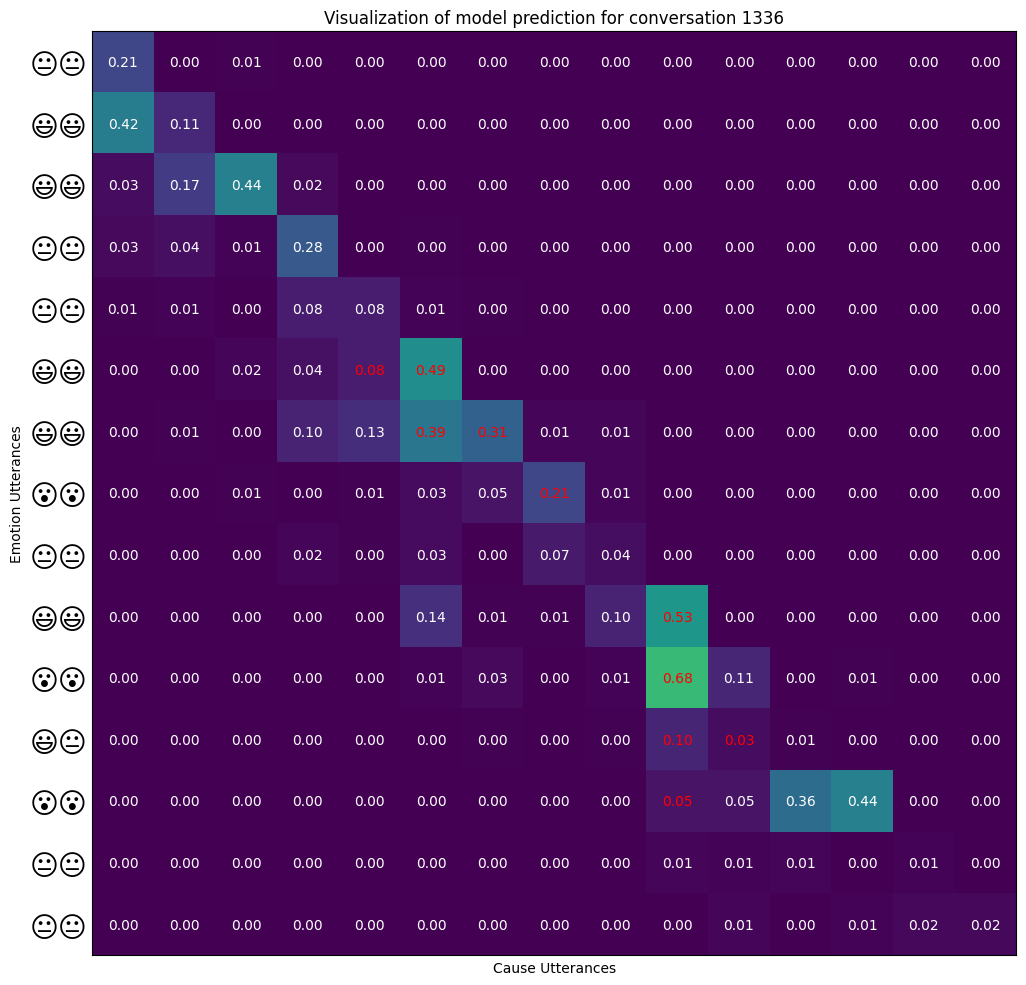

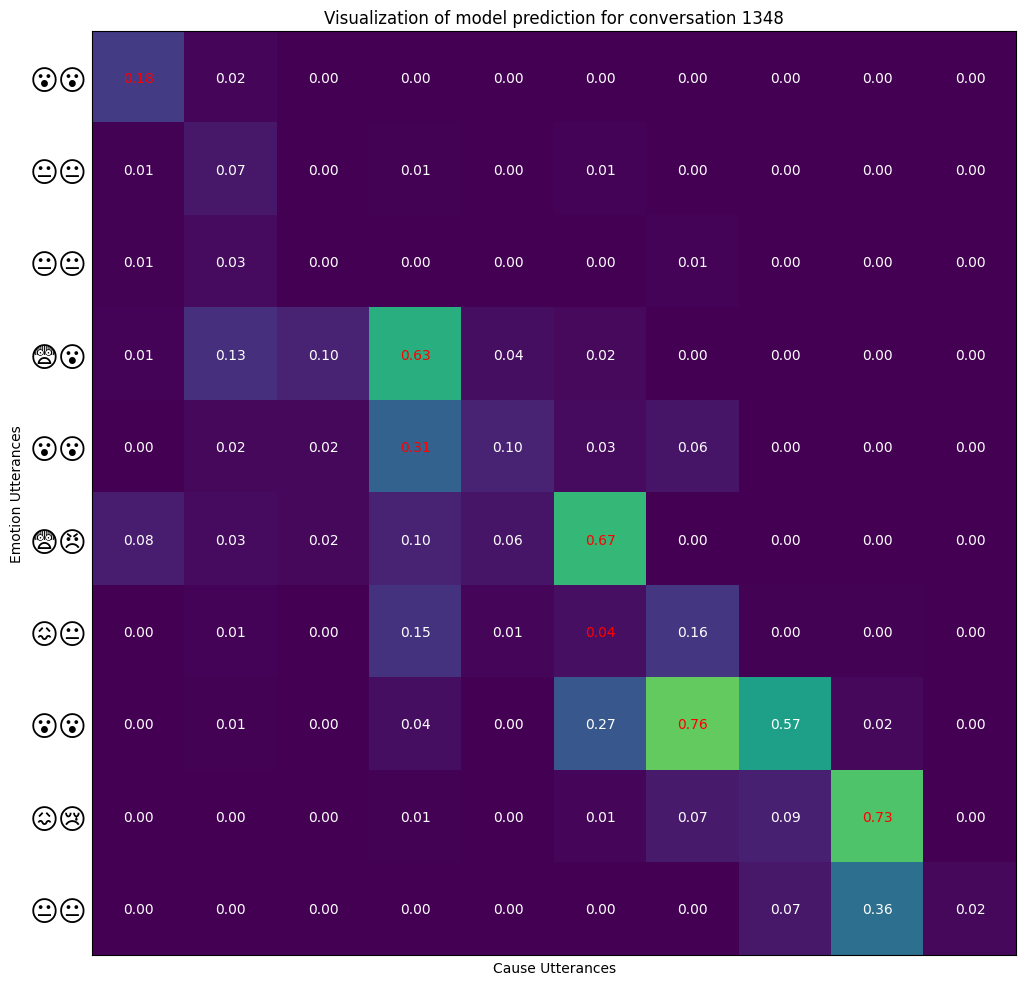

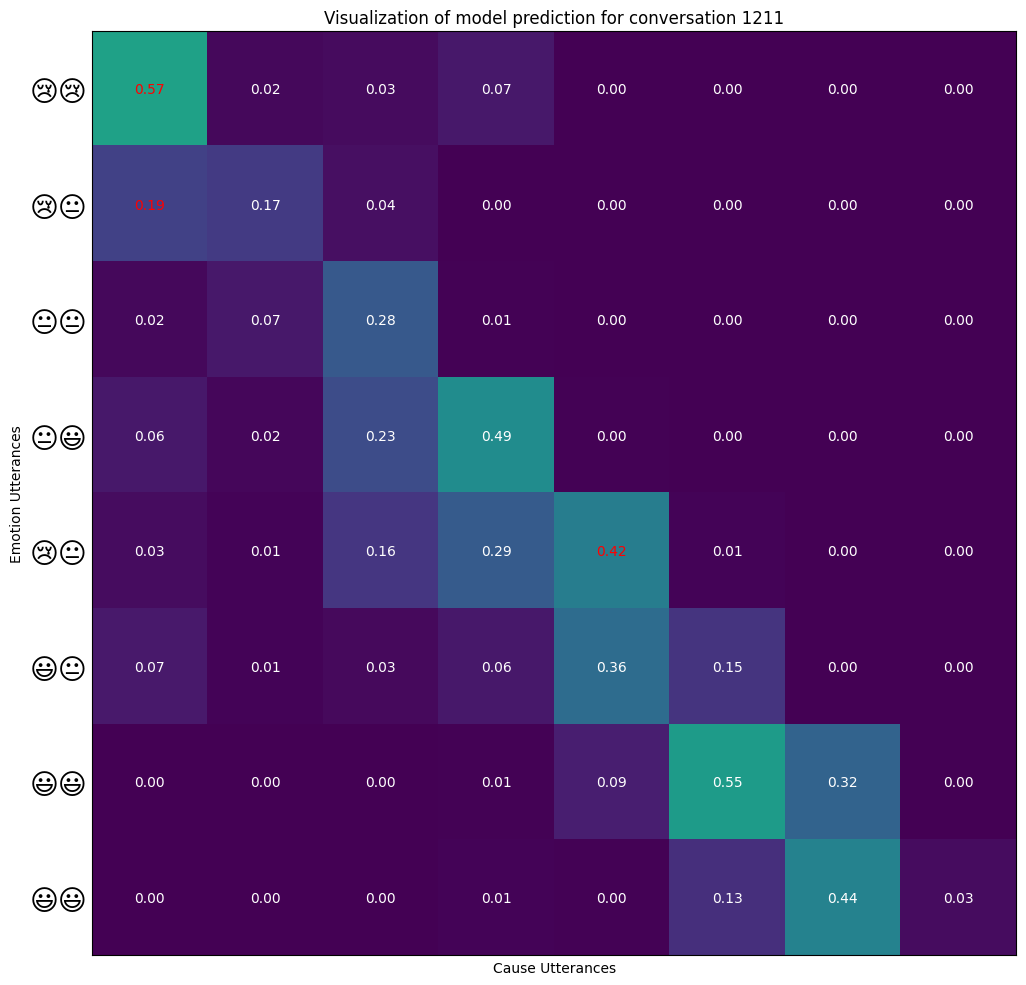

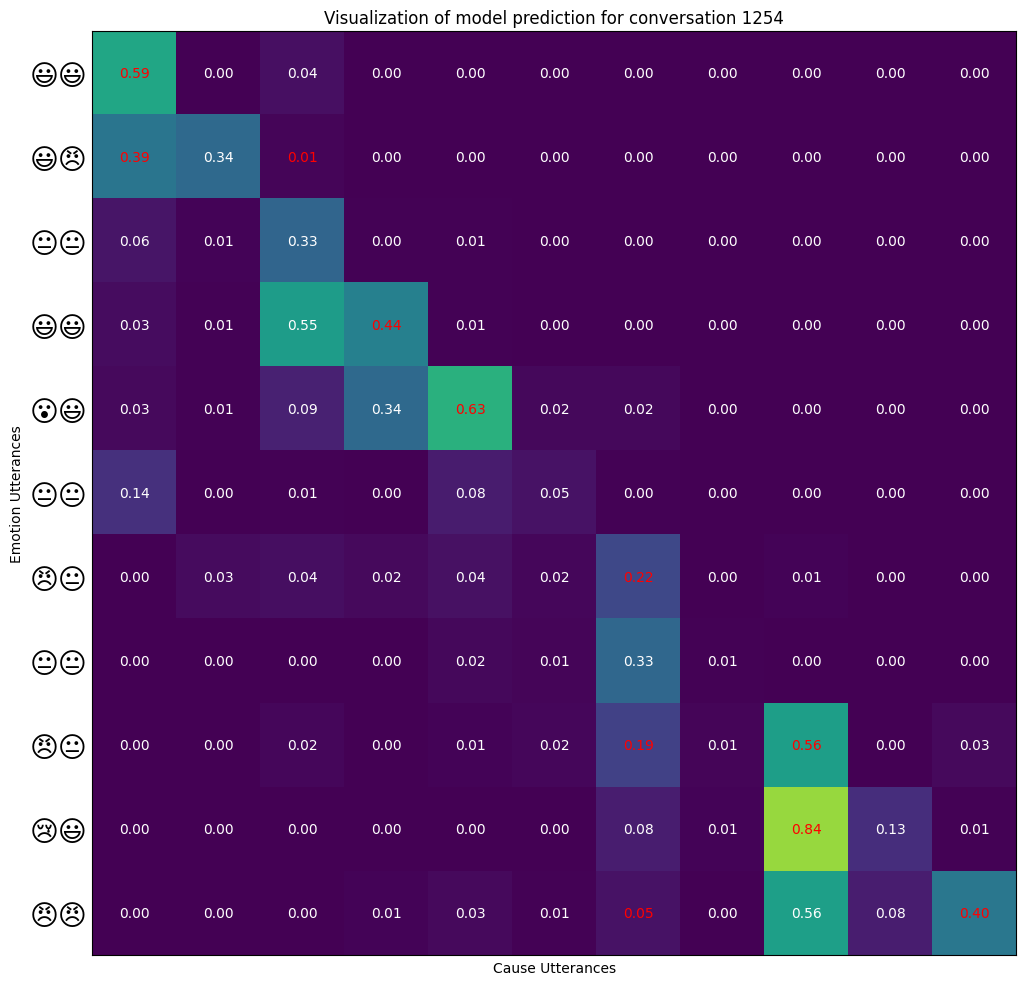

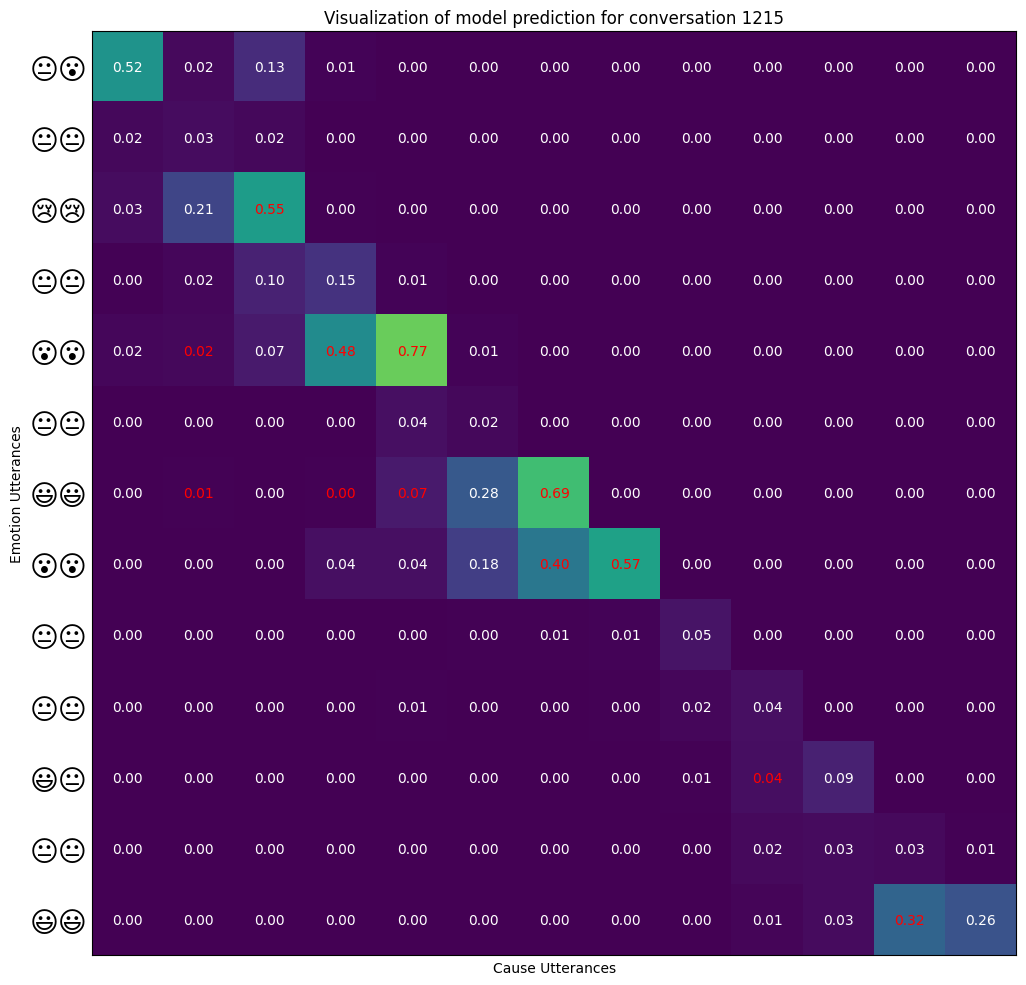

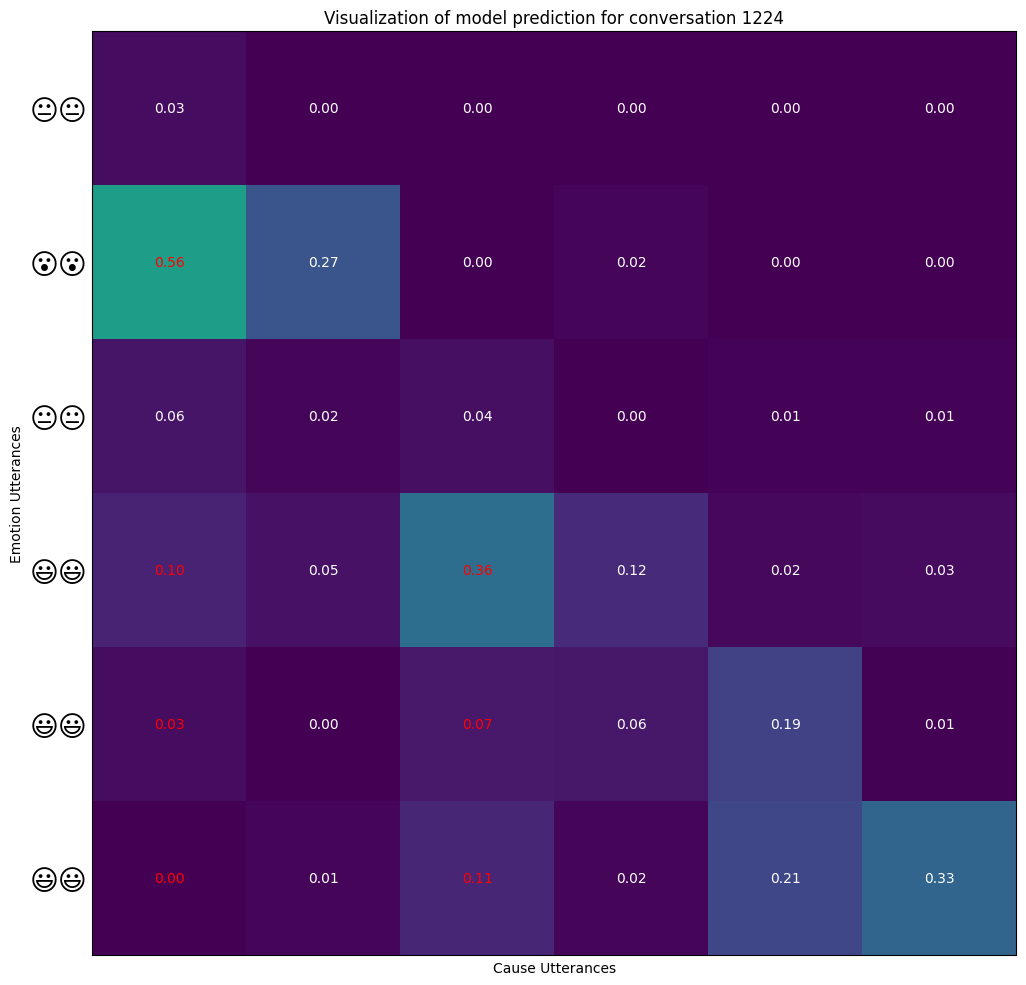

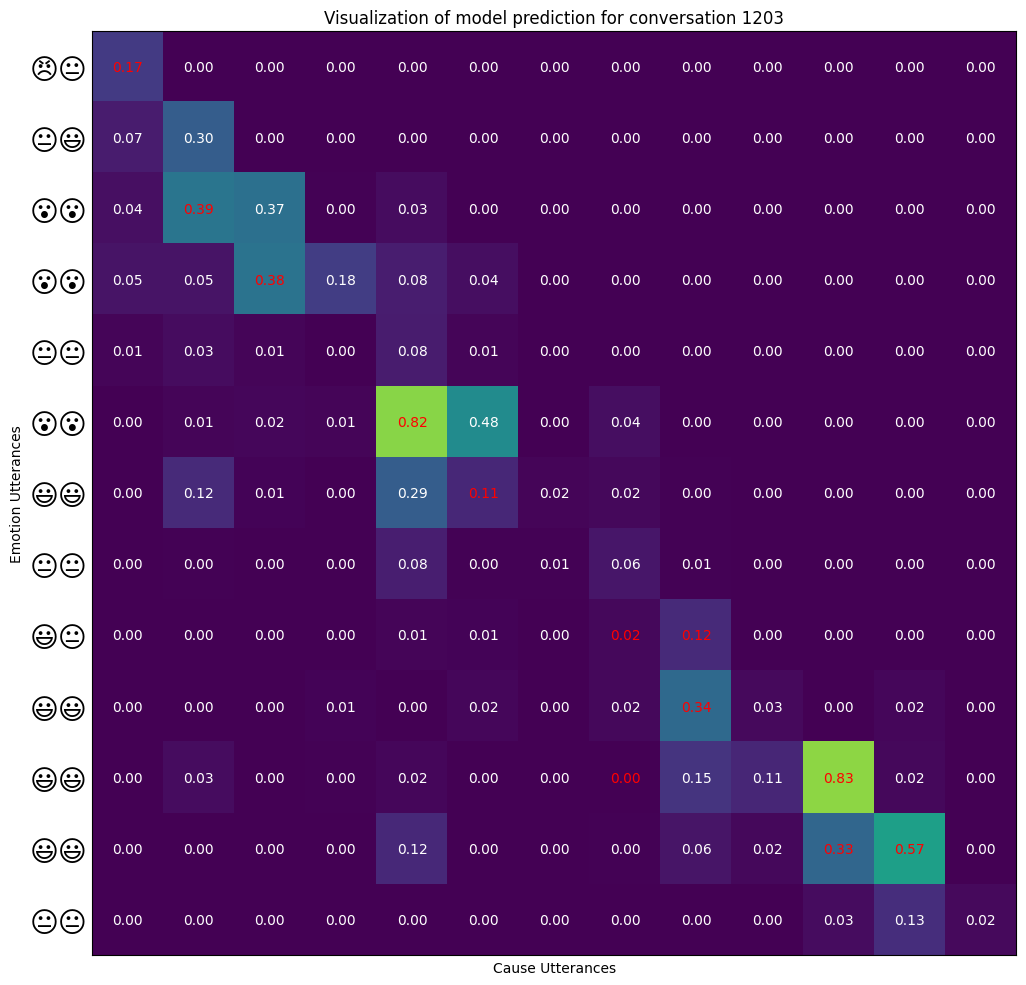

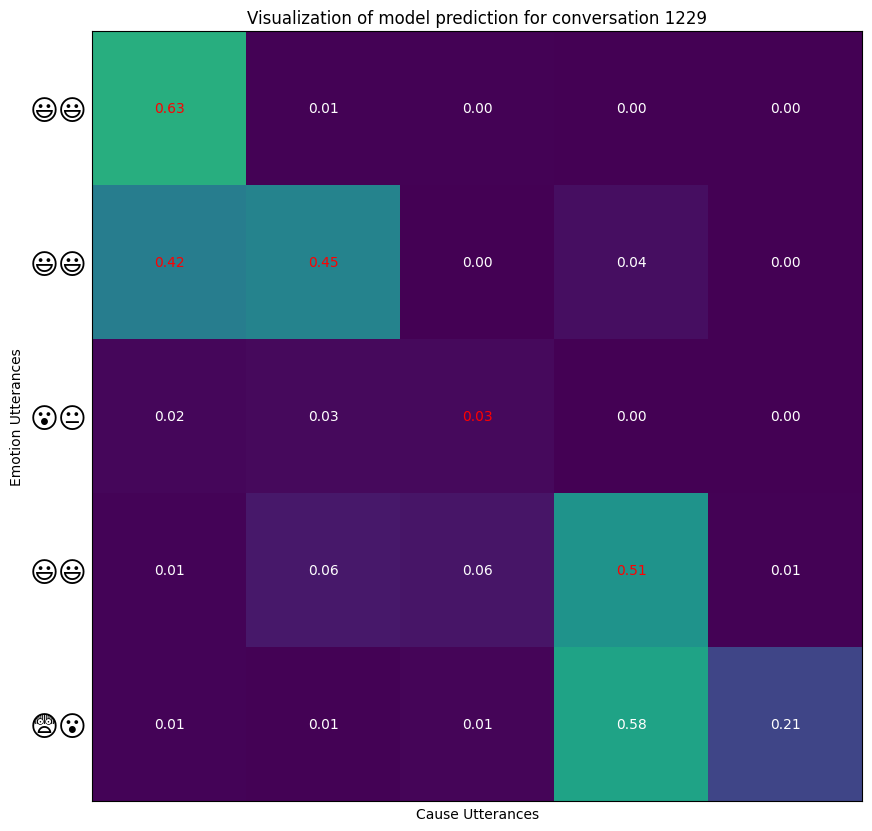

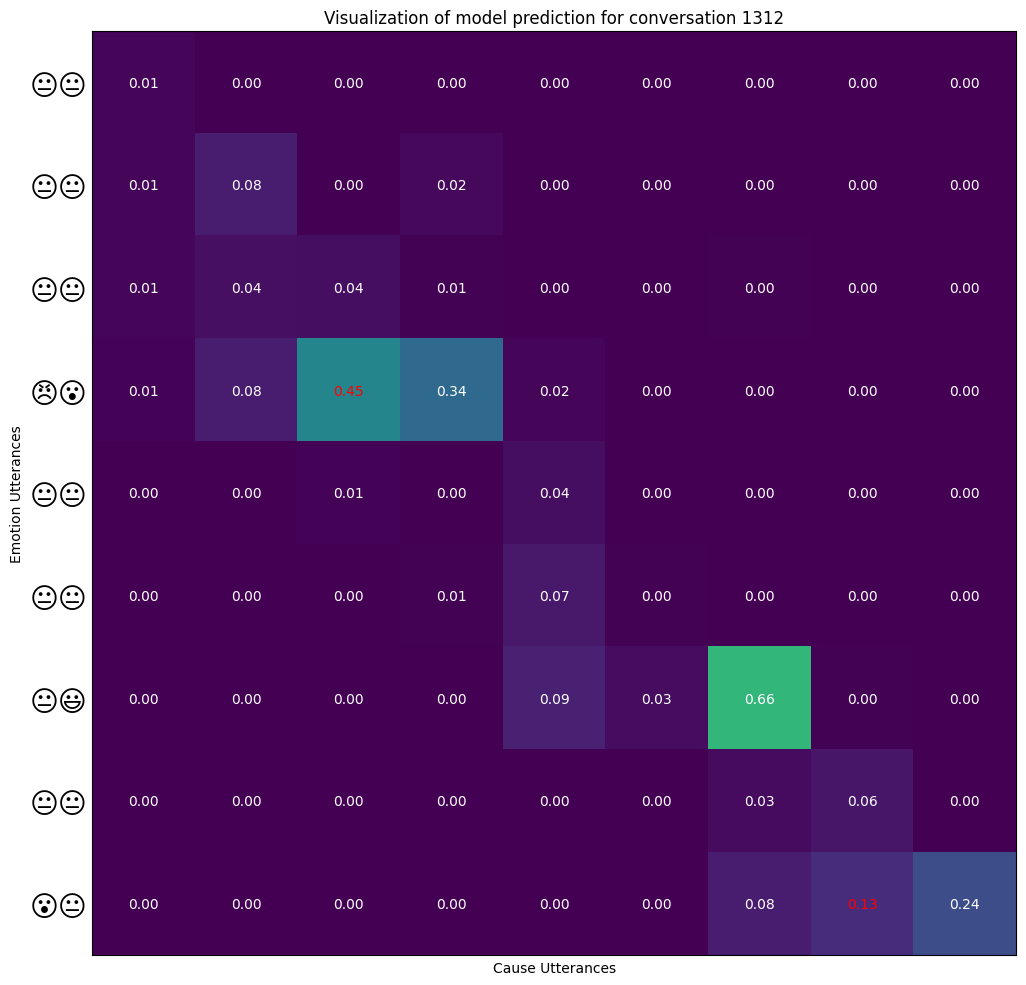

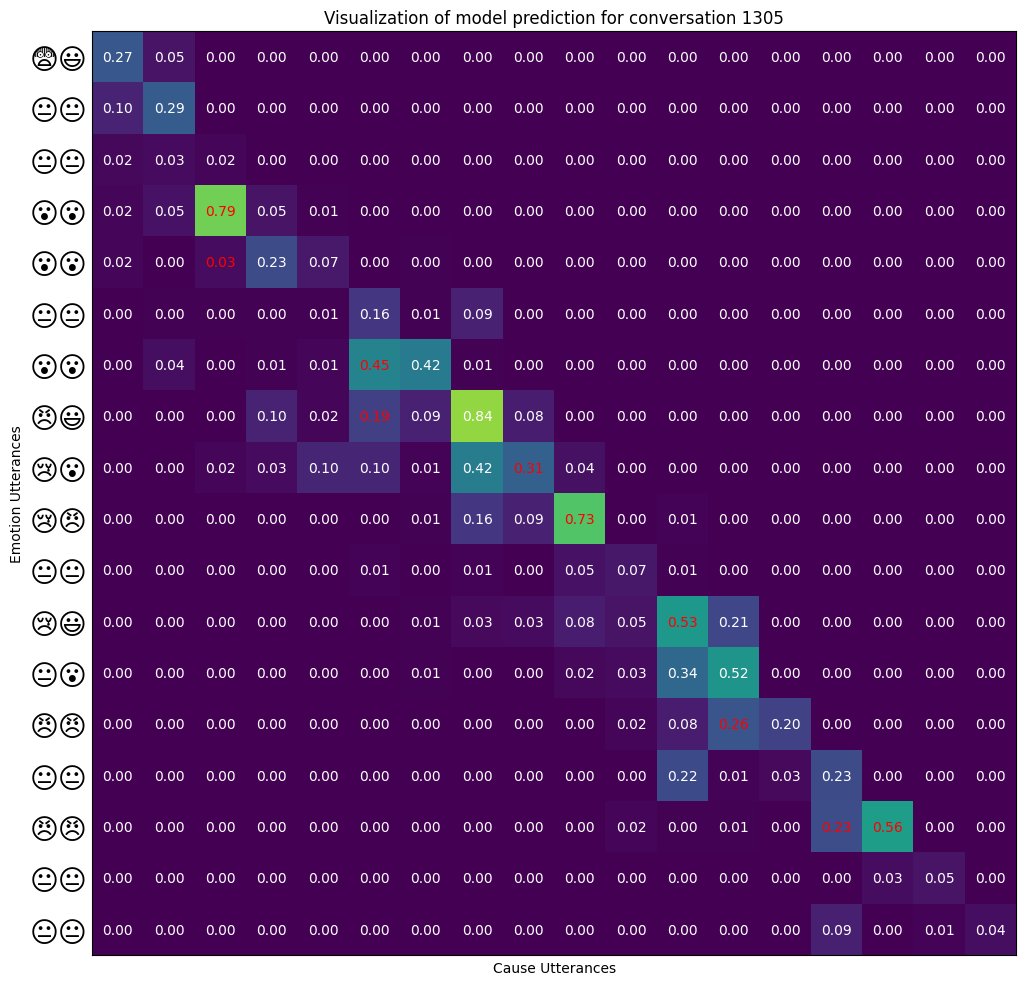

In [12]:
emo_classifier = tf.keras.models.load_model(f"{HOME_DIR}/models/emo_model_mlp.keras")


cause_classifier = tf.keras.models.load_model(
  f"{HOME_DIR}/models/cause_model_mix_labels_0.keras"
)

emotions_pred, causes_pred = get_predictions(emo_classifier,
                                              cause_classifier,
                                              conversations, emotions,
                                              causes, indicies)

for i in range(10):
  visualize_model_predictions(i)